# The most destructive hurricane events are becoming more frequent

One of the claims in our new paper is that hurricanes have become more frequent since 1900. This notebook allows you to experiment and see for yourself. 



Grinsted et al. https://www.pnas.org/content/early/2019/11/05/1912277116


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm

## Select data and load it

In [14]:
#inputdata = 'ICAT'
inputdata = 'Weinkle'
#field = 'ND' 
field = 'ATD'

df = pd.read_excel(r'Data\Dataset S1 - ATD.xls',sheet_name='ATD of {}'.format(inputdata))
df['year'] = pd.to_datetime(df.lf_ISO_TIME.values).year
df['decade'] = np.floor(df['year']/10)*10

if field=='ND':
    multiplier = 1e-9
    units = 'bn'
    threshold = 20
else:
    multiplier = 1 
    units = 'km2'
    threshold = 800


## Make a plot of the input data

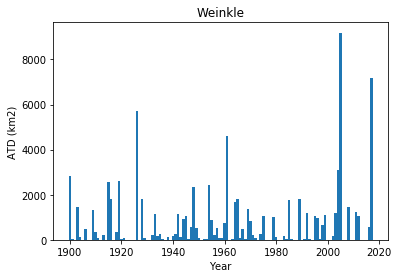

In [15]:
new_index = pd.Index(np.arange(df.year.min(),df.year.max()+1), name="year")
D = df.groupby(['year'])[field].agg('sum')
D = D.reindex(new_index)
D.fillna(0,inplace = True)

ty = D.index.values 
V = D.values* multiplier

plt.bar(ty,V,width=1)
plt.xlabel('Year')
plt.ylabel('{} ({})'.format(field,units));
plt.title(inputdata);


## calculate decadal frequencies of events above threshold

In [16]:
x = df['lf_ISO_TIME'].values
y = df[field].values * multiplier
x = x[y>=0] #remove nans
y = y[y>=0] #remove nans

window = np.timedelta64(10*365,'D')

tstart = np.datetime64(datetime.datetime(pd.to_datetime(np.min(x)).year,1,1))
tend = np.datetime64(datetime.datetime(pd.to_datetime(np.max(x)).year,12,31))

t = np.arange(tstart+window/2,tend-window/2,np.timedelta64(365,'D'))

tx = (t-np.datetime64(datetime.datetime(1900,7,1)))/np.timedelta64(1,'D')
tx = tx/365.25+1900

count = np.empty(t.size)
for ix,ti in enumerate(t):
    count[ix] = np.sum((x>ti-window/2) & (x<ti+window/2) & (y>=threshold))


C:\Users\ag\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ag\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.


## Calculate Trend on events per year data.

In [17]:

# Count the number of events per year above the threshold 
tt = pd.Index(np.arange(df.year.min(),df.year.max()+1), name="year")
D = df.groupby(['year'])[field].agg(lambda x: np.sum(x*multiplier>=threshold))
D = D.reindex(tt)
D.fillna(0,inplace = True)

# Fit a poisson trend
tt = D.index.values - 1950   
Ny = D.values
X = sm.add_constant(tt, prepend=False)
glm_poisson = sm.GLM(Ny, X, family=sm.families.Poisson())
res = glm_poisson.fit()        
y_model = res.predict(X)*10 
tt = tt+1950

slope = (y_model[tt==2000]/y_model[tt==1900])[0]


## Plot the results

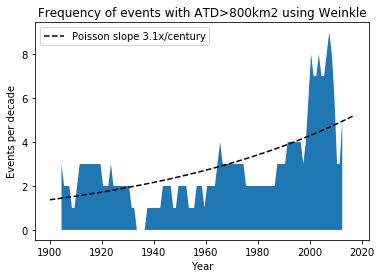

In [18]:

plt.fill_between(tx,count,count*0)
plt.xlabel('Year')
plt.title('Frequency of events with {}>{}{} using {}'.format(field,threshold,units,inputdata));
plt.ylabel('Events per decade');

plt.plot(tt,y_model,'k--',label='Poisson slope {:.1f}x/century'.format(slope))
plt.legend(loc='upper left')

## Are the Early and Late halves of the series different?
This is not a test from the paper. This is simpler. Are the observed counts in the Early half of the series statistically different from the count in the Late Half.

In [59]:
EarlyCount = np.sum(Ny[tt<np.mean(tt)])
LateCount = np.sum(Ny[tt>np.mean(tt)])

print('----------- {}>{}{} using {} -------------'.format(field,threshold,units,inputdata))
print('Early half of the series has {:.0f} events'.format(EarlyCount))
print(' Late half of the series has {:.0f} events '.format(LateCount))


----------- ATD>800km2 using Weinkle -------------
Early half of the series has 11 events
 Late half of the series has 23 events 


## What is the p-value of the early vs late count difference?

Could a difference between Early and Late counts be this much different just by chance. The null hypothesis we test against is that the total number of events is divided randomly between the two pools (i.e. no trend).

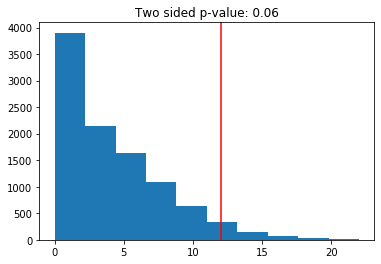

In [58]:
observed_diff= np.abs(LateCount-EarlyCount)

Ntotal = int(EarlyCount+LateCount)

#divide Ntotal number of balls randomly between two baskets
E = np.random.randint(2,size=(10000,Ntotal)) 
E = np.sum(mc,axis=1)
L = Ntotal-E
diff = np.abs(E-L)

pvalue = np.sum(diff>=observed_diff) / diff.size
plt.hist(diff)
plt.axvline(observed_diff,color='r')

plt.title('Two sided p-value: {:.1g}'.format(pvalue));
